In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import sklearn
import time

sections:
- feature selection; Spearman correlation and significant p 
- bivariate analysis; check frequency plot 
- classifers
    - with accuracy
    - logistic regression
    - model tuning; lasso and ridge
    - knn
    - randomforest

In [20]:
df = pd.read_csv('Phishing_Legitimate_full.csv')
df.rename(columns={'CLASS_LABEL': 'labels'}, inplace=True)

df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  10000 non-null  int64  
 1   NumDots                             10000 non-null  int64  
 2   SubdomainLevel                      10000 non-null  int64  
 3   PathLevel                           10000 non-null  int64  
 4   UrlLength                           10000 non-null  int64  
 5   NumDash                             10000 non-null  int64  
 6   NumDashInHostname                   10000 non-null  int64  
 7   AtSymbol                            10000 non-null  int64  
 8   TildeSymbol                         10000 non-null  int64  
 9   NumUnderscore                       10000 non-null  int64  
 10  NumPercent                          10000 non-null  int64  
 11  NumQueryComponents                  10000 

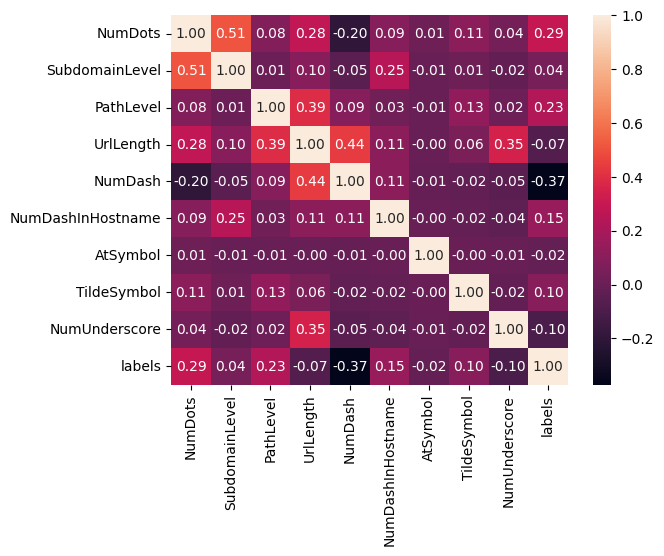

0.326267568366011 1.071355093865511e-246


In [21]:
def corr_heatmap(df, idx_s, idx_e):
    y = df['labels']
    temp = df.iloc[:, idx_s:idx_e]
    if 'id' in temp.columns:
        del temp['id']
    temp['labels'] = y
    sns.heatmap(temp.corr(), annot=True, fmt='.2f')
    plt.show()


corr_heatmap(df, 0, 10)

coef, p = scipy.stats.spearmanr(df['labels'], df['NumDots'])
print (coef, p)

feature selection
- suppress warnings if ConstantInputWarning due to null output for zero correlation of variables

In [43]:
import warnings

def constantwn():
    warnings.warn("", scipy.stats.ConstantInputWarning)

features = pd.DataFrame(columns=['name', 'coef'])
coeflist = []
namelist = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in df:
        coef, p = scipy.stats.spearmanr(df['labels'], df[col])
        if p < 0.05 and abs(coef) > 0.25:
            namelist.append(col)
            coeflist.append(coef)
        
print(coeflist)
print(namelist)

[0.32676560547860667, 0.2510998957211466, -0.31175564381538967, 0.26693504754390374, 0.3163100141228587, 0.4639104105922682, -0.3577529392521163, -0.5142439324562876, 1.0]
['NumDots', 'PathLevel', 'NumDash', 'NumSensitiveWords', 'InsecureForms', 'FrequentDomainNameMismatch', 'SubmitInfoToEmail', 'PctExtNullSelfRedirectHyperlinksRT', 'labels']


univariate analysis:
- check distributions
- handling outliers

NumDots
2     4053
3     2723
1     1959
4      795
5      239
6      100
7       49
8       26
15      10
9       10
14       9
11       8
12       6
10       6
13       4
16       2
21       1
Name: count, dtype: int64
PathLevel
3     2485
2     2445
4     1618
5     1261
1      882
6      464
0      335
7      226
8      130
9       79
10      29
11      16
14      10
12       8
13       5
15       3
18       3
16       1
Name: count, dtype: int64
NumDash
0     5001
1     2103
2      657
3      398
5      338
4      312
6      273
7      211
8      186
9      135
10     101
11     101
12      53
13      39
14      26
15      20
16      12
18      10
17       8
20       5
23       5
19       3
26       1
24       1
55       1
Name: count, dtype: int64
NumSensitiveWords
0    9089
1     740
2     160
3      11
Name: count, dtype: int64
InsecureForms
1    8440
0    1560
Name: count, dtype: int64
FrequentDomainNameMismatch
0    7847
1    2153
Name: count, dtype: int64
SubmitInfoToEmail
0

(9998, 50)

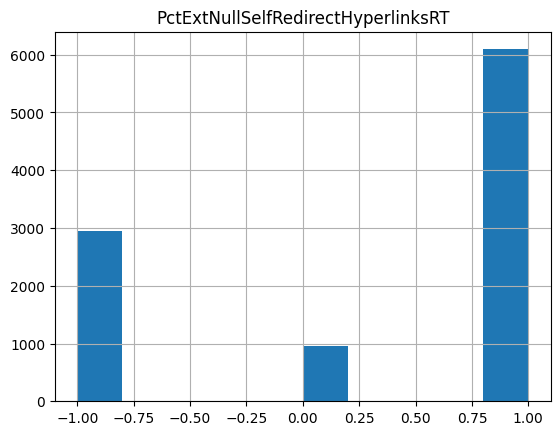

In [23]:
df.hist(column='PctExtNullSelfRedirectHyperlinksRT')

for col in namelist:
    print(df[col].value_counts())

df = df.loc[df['NumDots'] != 21]
df = df.loc[df['NumDash'] != 55]

df.shape

bivariate analysis
- multicollinearity

In [24]:
df[namelist].corr(method='spearman')
namelist.remove('labels')


Null model and cross validation

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df[namelist]
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape
X_test.shape, y_test.shape

# null model
max(y_test.mean(), 1 - y_test.mean())


0.5066666666666666

logistic regression

In [26]:
logreg = LogisticRegressionCV(scoring=None)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print(accuracy_score(y_test, y_pred_logreg))
coef_table1 = pd.DataFrame(list(X_train.columns)).copy()
coef_table1.insert(len(coef_table1.columns),"Coefs",logreg.coef_.transpose())
coef_table1['abs'] = coef_table1['Coefs'].abs()
coef_table1.sort_values(by=['abs'],ascending=False)

0.8606666666666667


,0,Coefs,abs
6,SubmitInfoToEmail,-3.290147,3.290147
5,FrequentDomainNameMismatch,2.089165,2.089165
4,InsecureForms,2.071689,2.071689
3,NumSensitiveWords,1.381824,1.381824
7,PctExtNullSelfRedirectHyperlinksRT,-1.357073,1.357073
2,NumDash,-0.495118,0.495118
1,PathLevel,0.440787,0.440787
0,NumDots,0.369500,0.369500


with tuning

In [27]:
logreg2 = LogisticRegressionCV()
logreg2.fit(X_train, y_train)

y_pred_logreg2 = logreg2.predict(X_test)

print(accuracy_score(y_test, y_pred_logreg2))
coef_table2 = pd.DataFrame(list(X_train.columns)).copy()
coef_table2.insert(len(coef_table2.columns),"Coefs",logreg2.coef_.transpose())

coef_table2['abs'] = coef_table2['Coefs'].abs()
coef_table2.sort_values(by=['abs'],ascending=False)

0.8606666666666667


,0,Coefs,abs
6,SubmitInfoToEmail,-3.290147,3.290147
5,FrequentDomainNameMismatch,2.089165,2.089165
4,InsecureForms,2.071689,2.071689
3,NumSensitiveWords,1.381824,1.381824
7,PctExtNullSelfRedirectHyperlinksRT,-1.357073,1.357073
2,NumDash,-0.495118,0.495118
1,PathLevel,0.440787,0.440787
0,NumDots,0.369500,0.369500


knn

In [28]:
df = df.drop(['id'], axis=1)
df.head()

,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,NumPercent,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,labels
0,3,1,5,72,0,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,3,1,3,144,0,0,0,0,2,0,...,0,0,0,1,-1,1,1,1,1,1
2,3,1,2,58,0,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1
3,3,1,6,79,1,0,0,0,0,0,...,0,0,0,1,-1,1,1,1,-1,1
4,3,0,4,46,0,0,0,0,0,0,...,1,0,0,1,1,-1,0,-1,-1,1


In [29]:
neigh1 = KNeighborsClassifier()
neigh1.fit(X_train, y_train)

y_pred_neigh1 = neigh1.predict(X_test)

print('uniform:', accuracy_score(y_test, y_pred_neigh1))

neigh2 = KNeighborsClassifier(weights='distance')

neigh2.fit(X_train, y_train)

y_pred_neigh2 = neigh2.predict(X_test)
print('distance:', accuracy_score(y_test, y_pred_neigh2))


uniform: 0.8676666666666667
distance: 0.8696666666666667


randomforest with preselected features

In [30]:
rf1 = RandomForestClassifier()
rf1.fit(X_train, y_train)

y_pred_rf1 = rf1.predict(X_test)

print(accuracy_score(y_test, y_pred_rf1))

0.885


randomforest automatic 

In [31]:
X = df.loc[:, df.columns != 'labels']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)

y_pred_rf2 = rf2.predict(X_test)

print(accuracy_score(y_test, y_pred_rf2))



0.9783333333333334


In [32]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(rf2, X_test, y_test)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

Elapsed time to compute the importances: 5.751 seconds


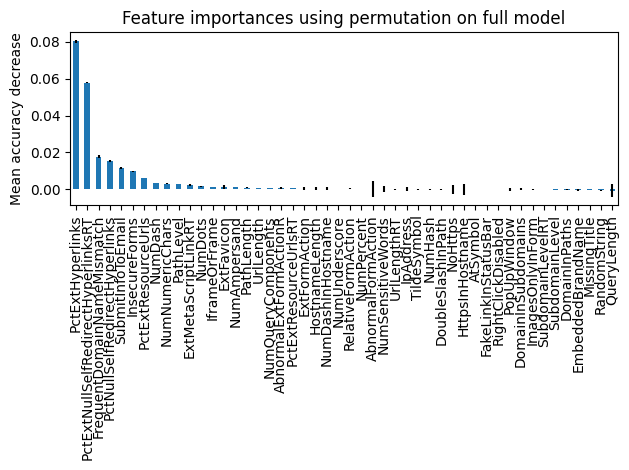

In [33]:
fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [34]:
temp = forest_importances.sort_values(ascending=False).head(9)
temp

PctExtHyperlinks                      0.080200
PctExtNullSelfRedirectHyperlinksRT    0.057867
FrequentDomainNameMismatch            0.017733
PctNullSelfRedirectHyperlinks         0.015267
SubmitInfoToEmail                     0.011533
InsecureForms                         0.009667
PctExtResourceUrls                    0.006133
NumDash                               0.003400
NumNumericChars                       0.003000
dtype: float64